In [1]:
!pip install datasets transformers torch
!pip install transformers[torch]
!pip install accelerate -U
!pip install kaggle
!pip install lime
!pip install shap
!pip install torchvision
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 6.7 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
# Verify the installation and version of accelerate
import accelerate
print(accelerate.__version__)

# Verify the installation and version of transformers
import transformers
print(transformers.__version__)
from datasets import load_dataset
from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification, TrainingArguments, Trainer
import torch
import numpy as np
from datasets import load_metric

import tensorflow as tf
print(tf.__version__)


from tensorflow.keras import layers, Sequential

0.33.0
4.42.3


2024-08-18 04:17:13.185122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 04:17:13.185243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 04:17:13.313161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray > /dev/null 2>&1

In [3]:
path = '/kaggle/working/chest_xray/chest_xray/chest_xray'
dataset = load_dataset('imagefolder', data_dir=path)
print("✔")

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

✔


In [4]:
# Split dataset
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(2, ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None))

<Axes: xlabel='Label', ylabel='count'>

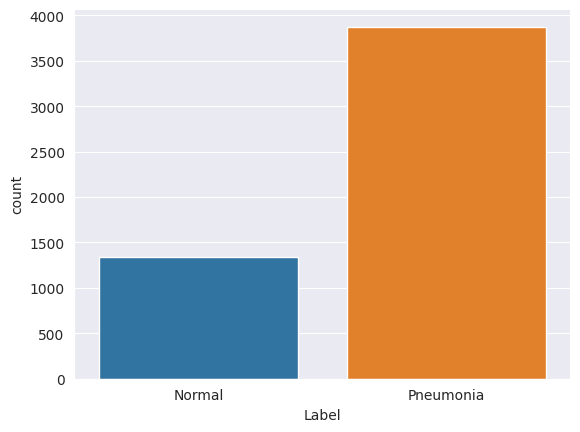

In [5]:
import pandas as pd
import seaborn as sns
l = []

for item in dataset_train:
    if item['label'] == 0:
        l.append("Normal")
    else:
        l.append("Pneumonia")
        
df = pd.DataFrame({'Label': l})
sns.set_style('darkgrid')
sns.countplot(x='Label', data=df)

Text(0.5, 1.0, 'Pneumonia')

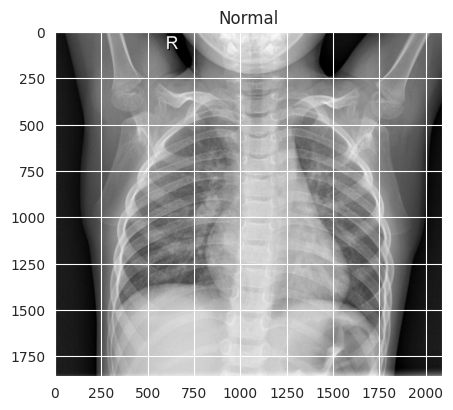

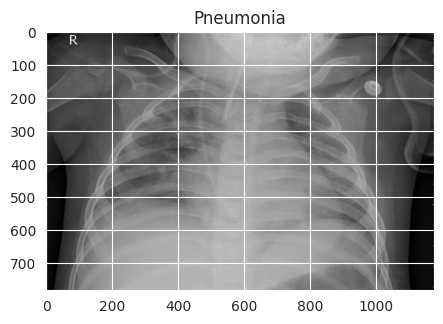

In [6]:
import matplotlib.pyplot as plt
labels = ['Normal', 'Pneumonia']
plt.figure(figsize = (5,5))
plt.imshow(dataset_train[0]['image'], cmap='gray')
plt.title(labels[dataset_train[0]['label']])

plt.figure(figsize = (5,5))
plt.imshow(dataset_train[-1]['image'], cmap='gray')
plt.title(labels[dataset_train[-1]['label']])

In [5]:
dataset_train

Dataset({
    features: ['image', 'label'],
    num_rows: 5216
})

## Data Augmentation

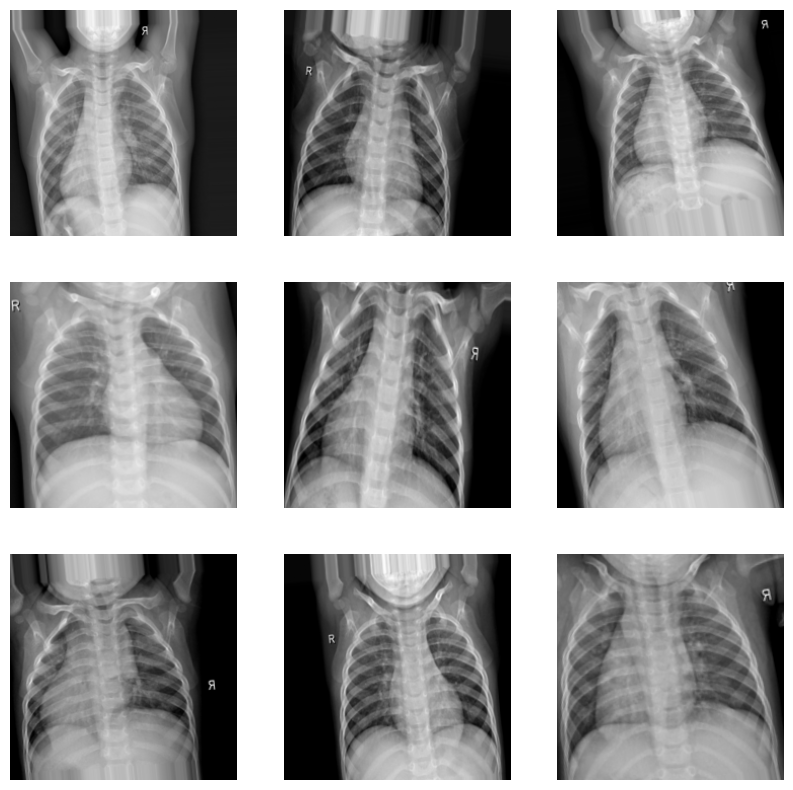

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

# Define a function to convert images to a consistent format
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        if isinstance(img, np.ndarray):
            # Ensure images are in RGB format and resize
            img = Image.fromarray(img).convert("RGB")
        elif isinstance(img, Image.Image):
            img = img.convert("RGB")
        # Resize image
        img = img.resize(target_size)
        # Convert image to numpy array and normalize to [0, 1]
        img_array = np.array(img) / 255.0
        processed_images.append(img_array)
    return np.array(processed_images)

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

def augment_images(images, labels):
    # Preprocess images
    images = preprocess_images(images)
    labels = np.array(labels)
    
    # Create a generator for augmented images
    datagen.fit(images)
    
    # Use the generator to get augmented images
    augmented_images = []
    augmented_labels = []
    for batch in datagen.flow(images, labels, batch_size=32, shuffle=False):
        augmented_images.extend(batch[0])
        augmented_labels.extend(batch[1])
        if len(augmented_images) >= len(images):
            break

    return np.array(augmented_images), np.array(augmented_labels)

# Example usage
images = [item['image'] for item in dataset_train]
labels = [item['label'] for item in dataset_train]
augmented_images, augmented_labels = augment_images(images, labels)


# Display some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [7]:
from datasets import Dataset, concatenate_datasets, Features, ClassLabel, Image
from PIL import Image as PILImage
import numpy as np

# Convert augmented images to PIL format
augmented_images_pil = [PILImage.fromarray((img * 255).astype(np.uint8)) for img in augmented_images]

# Define dataset features
features = Features({
    'image': Image(decode=True),
    'label': ClassLabel(names=['Normal', 'Pneumonia'])
})

# Create a new dataset with augmented images and labels
augmented_dataset = Dataset.from_dict({
    'image': augmented_images_pil,  # Use PIL images
    'label': augmented_labels
}, features=features)

# Ensure the original dataset has the same features
dataset_train = dataset_train.cast(features)

# Combine with the original dataset
combined_dataset = concatenate_datasets([dataset_train, augmented_dataset])

Casting the dataset:   0%|          | 0/5216 [00:00<?, ? examples/s]

In [6]:
combined_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10432
})

In [7]:
combined_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858>,
 'label': 0}

In [8]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
from PIL import Image

def preprocess(batch):
    # Convert images to RGB if they are not already
    images = [img.convert("RGB") if isinstance(img, Image.Image) else Image.fromarray(img).convert("RGB") for img in batch['image']]
    inputs = feature_extractor(
        images,
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs


prepared_train = combined_dataset.with_transform(preprocess)
prepared_val = dataset_val.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [10]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [11]:
metric = load_metric("accuracy",trust_remote_code=True)

def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids

    )

/tmp/ipykernel_34/1584353940.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy",trust_remote_code=True)


In [12]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./Pneumonia_Dataset",
    per_device_train_batch_size=8,
    eval_strategy="steps",
    num_train_epochs=5,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

In [13]:
from transformers import ViTForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_classes
)

model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_val,
    tokenizer=feature_extractor,
)


In [15]:
import wandb
import json

with open('config.json', 'r') as file:
    config = json.load(file)

# Initialize wandb
wandb.login(key=config['wandb_api_key'])
wandb.init(project="chest-xray-pneumonia")

# Your training code
train_results = trainer.train()

# Save the model and tokenizer
trainer.save_model()

# Log metrics
wandb.log(train_results.metrics)

# Save metrics
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Evaluate the model
metrics = trainer.evaluate(prepared_test)

# Log and save evaluation metrics
wandb.log(metrics)
trainer.save_metrics("eval", metrics)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: my6580861 (my6580861-university-of-engineering-and-technology-lahore). Use `wandb login --relogin` to force relogin


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.213600,0.498571,0.812500
200,0.135100,0.316165,0.750000
300,0.120800,1.395620,0.625000
400,0.121400,0.639746,0.750000
500,0.245600,0.398579,0.750000
600,0.159900,0.932022,0.687500
700,0.015000,0.164012,0.937500
800,0.039300,1.687311,0.625000
900,0.209100,0.462986,0.812500
1000,0.078900,1.502968,0.562500


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.5 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.9 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 8.5 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 18.9 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 35.3 seconds.), retrying request
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 71.5 seconds.), retrying request
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimensio

In [16]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 3764389248GF
  train_loss               =         0.06
  train_runtime            =   0:30:58.76
  train_samples_per_second =       28.062
  train_steps_per_second   =        1.754


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


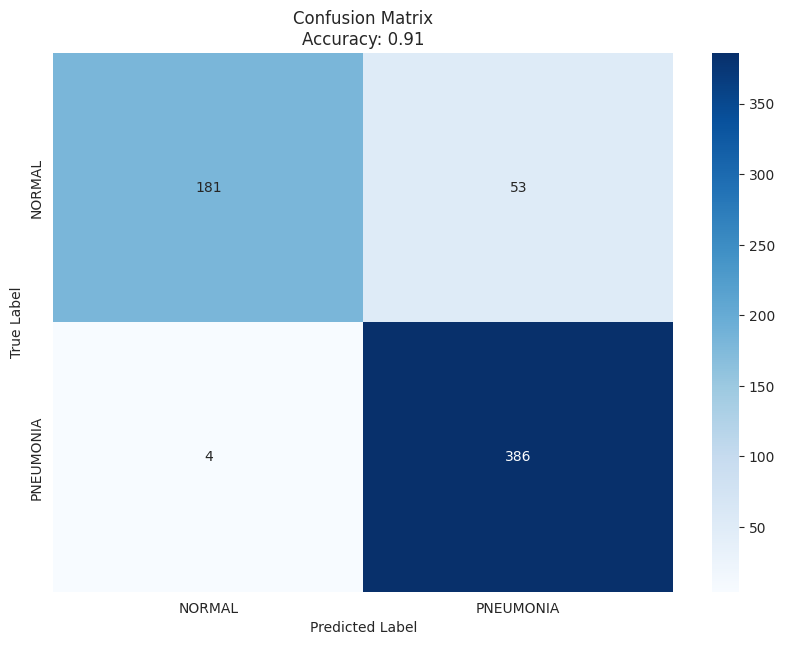

Accuracy: 0.91
                     Image Name Correct
0             IM-0001-0001.jpeg     Yes
1             IM-0003-0001.jpeg     Yes
2             IM-0005-0001.jpeg     Yes
3             IM-0006-0001.jpeg     Yes
4             IM-0007-0001.jpeg     Yes
..                          ...     ...
619  person96_bacteria_465.jpeg     Yes
620  person96_bacteria_466.jpeg     Yes
621  person97_bacteria_468.jpeg     Yes
622  person99_bacteria_473.jpeg     Yes
623  person99_bacteria_474.jpeg     Yes

[624 rows x 2 columns]


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import os # Import the os module
# Make predictions on the test set
test_predictions = trainer.predict(prepared_test)
preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids

image_filenames = []
for img in dataset_test['image']:
    if isinstance(img, str):  # Check if it's already a filename string
        image_filenames.append(img)
    elif hasattr(img, 'filename'):  # Check if it has a filename attribute (e.g., PIL Image)
        image_filenames.append(os.path.basename(img.filename))  # Extract filename
    else:
        image_filenames.append('Unknown') # Handle cases where filename is not available
# #image_filenames = dataset_test['image']
# if isinstance(dataset_test['image'][0], str):  # Check if the first element is already a string
#     image_filenames = dataset_test['image']
# else:
#     image_filenames = [img.filename for img in dataset_test['image']]  # Extract filenames


# Compute the confusion matrix
cm = confusion_matrix(labels, preds)
accuracy = accuracy_score(labels, preds)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset_test.features['label'].names, yticklabels=dataset_test.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

print(f'Accuracy: {accuracy:.2f}')

# Display image names and whether the prediction was correct
results = []
for img, label, pred in zip(image_filenames, labels, preds):
    #img_name = img.split('/')[-1]  # Extract the image name
    img_name = os.path.basename(img)  # Use os.path.basename to extract the file name
    correct = 'Yes' if label == pred else 'No'
    results.append((img_name, correct))

# Convert results to a DataFrame for better display
results_df = pd.DataFrame(results, columns=['Image Name', 'Correct'])
print(results_df)


In [69]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

# Path to your saved model directory
model_name_or_path = './Pneumonia_Dataset'  # Replace with your actual path

# Load the feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(model_name_or_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict on a single image
def predict_tb(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = preds.argmax(dim=1).item()

    return predicted_class, preds[0][predicted_class].item()

# Path to the image you want to test
# image_path = '/kaggle/working/chest_xray/chest_xray/test/PNEUMONIA/person66_virus_125.jpeg'  # Replace with your image path
image_path = '/kaggle/working/chest_xray/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0360-0001.jpeg'
# Predict on the image
predicted_class, confidence = predict_tb(image_path)
label_map = {0: 'No Pneumonia', 1: 'Pneumonia'}  # Adjust according to your label mapping
prediction = label_map[predicted_class]

# Print the prediction
print(f"Prediction: {prediction} (Confidence: {confidence:.2f})")


Prediction: Pneumonia (Confidence: 0.98)


## Upload Model at Hugging Face

In [19]:
!pip install huggingface_hub --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 9.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4


In [20]:
from huggingface_hub import notebook_login

notebook_login()


In [24]:
from huggingface_hub import create_repo

# Create a new repository on Hugging Face Hub
repo_id = "M-Yaqoob/PneumonoBot"  # Your repository name
create_repo(repo_id, repo_type="model", private=False)  # Set to private=True if you want the repo to be private


RepoUrl('https://huggingface.co/M-Yaqoob/PneumonoBot', endpoint='https://huggingface.co', repo_type='model', repo_id='M-Yaqoob/PneumonoBot')

In [25]:
from huggingface_hub import HfApi, HfFolder

# Load the model and tokenizer saved by Trainer
model_dir = "/kaggle/working/Pneumonia_Dataset"  # This is the directory where your model was saved

# Upload the model to Hugging Face
api = HfApi()
api.upload_folder(
    folder_path=model_dir,            # Path to the saved model directory
    repo_id="M-Yaqoob/PneumonoBot",  # Your Hugging Face repo name
    repo_type="model",                # Repository type: 'model'
    commit_message="Upload chest xray pneumonia model"
)


scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Upload 24 LFS files:   0%|          | 0/24 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1723183422.eaa1b9f70858.34.0:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

events.out.tfevents.1723183663.eaa1b9f70858.34.1:   0%|          | 0.00/9.37k [00:00<?, ?B/s]

events.out.tfevents.1723183690.eaa1b9f70858.34.2:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

events.out.tfevents.1723186885.eaa1b9f70858.686.0:   0%|          | 0.00/48.9k [00:00<?, ?B/s]

events.out.tfevents.1723187962.eaa1b9f70858.686.1:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

events.out.tfevents.1723189822.eaa1b9f70858.686.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1723192564.eaa1b9f70858.686.3:   0%|          | 0.00/164k [00:00<?, ?B/s]

events.out.tfevents.1723196266.eaa1b9f70858.686.4:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1723949598.3b593cd9e4c5.457.0:   0%|          | 0.00/322k [00:00<?, ?B/s]

events.out.tfevents.1723953443.3b593cd9e4c5.457.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1723955072.cb3c994ab188.34.0:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

events.out.tfevents.1723956950.cb3c994ab188.34.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/M-Yaqoob/PneumonoBot/commit/5ef04e3e6d7fe21043baee713b3d5cd3d0a1867c', commit_message='Upload chest xray pneumonia model', commit_description='', oid='5ef04e3e6d7fe21043baee713b3d5cd3d0a1867c', pr_url=None, pr_revision=None, pr_num=None)

wandb: 429 encountered (Filestream rate limit exceeded, retrying in 339.9 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 355.6 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 333.9 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 310.7 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 365.4 seconds.), retrying request
